In [1]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

% matplotlib inline

UsageError: Line magic function `%` not found.


Helper functions

In [2]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [3]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

RRT algorithm

In [4]:
def draw_map(obstacles, ax):
    # Obstacles. An obstacle is represented as a convex hull of a number of points. 
    # First row is x, second is y (position of vertices)

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    #fig = plt.figure(figsize=(10, 10))
    #plt.grid()
    #ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )

In [5]:
w = 0.3
obstacles = [
              np.array([[-2, 1], [-1.8, 1.8], [-1, 2], [-1, 1]]),
              np.array([[-0.8, 2], [0, 1.9], [0.5, 1], [-0.8, 1]]),
              np.array([[-2, 1], [-2.2, 0.5], [-1.5, -0.5], [-1.3, 1]]),
              np.array([[-1.3, -0.5], [-1.1, 0.9], [-0.5, 0.9], [-0.5, -0.9]]),
              np.array([[-0.5, -0], [-0.5, 0.5], [-0.35, 0.7], [-0.35, -0]]),
              np.array([[-0.35, 0.9], [0, 0.9], [0, -0.9], [-0.35, -0.9]]),
              np.array([[0.5, 1], [0.1, -0.9], [0.15, 0.5], [0.1, 1]]),
            ]
# draw_map(obstacles)

In [6]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [7]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

C:\Users\mispu\AppData\Local\Temp\ipykernel_6652\1837926016.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  xy_start = np.array([-0.4, 0.9]); ax.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=5)
C:\Users\mispu\AppData\Local\Temp\ipykernel_6652\1837926016.py:114: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=2) # VERTICES


Number of iterations passed: 2500 / 2500
RRT length:  1596
Entry nodes:  1


C:\Users\mispu\AppData\Local\Temp\ipykernel_6652\1837926016.py:129: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(node.p[0],node.p[1],'bo',color='green', markersize=13)


Number of iterations passed: 2500 / 2500
RRT length:  1771
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1611
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1840
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1787
Entry nodes:  1
Number of iterations passed: 2500 / 2500
RRT length:  1784
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1438
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1720
Entry nodes:  1
Number of iterations passed: 2500 / 2500
RRT length:  1783
Entry nodes:  2
Number of iterations passed: 2500 / 2500
RRT length:  1834
Entry nodes:  2


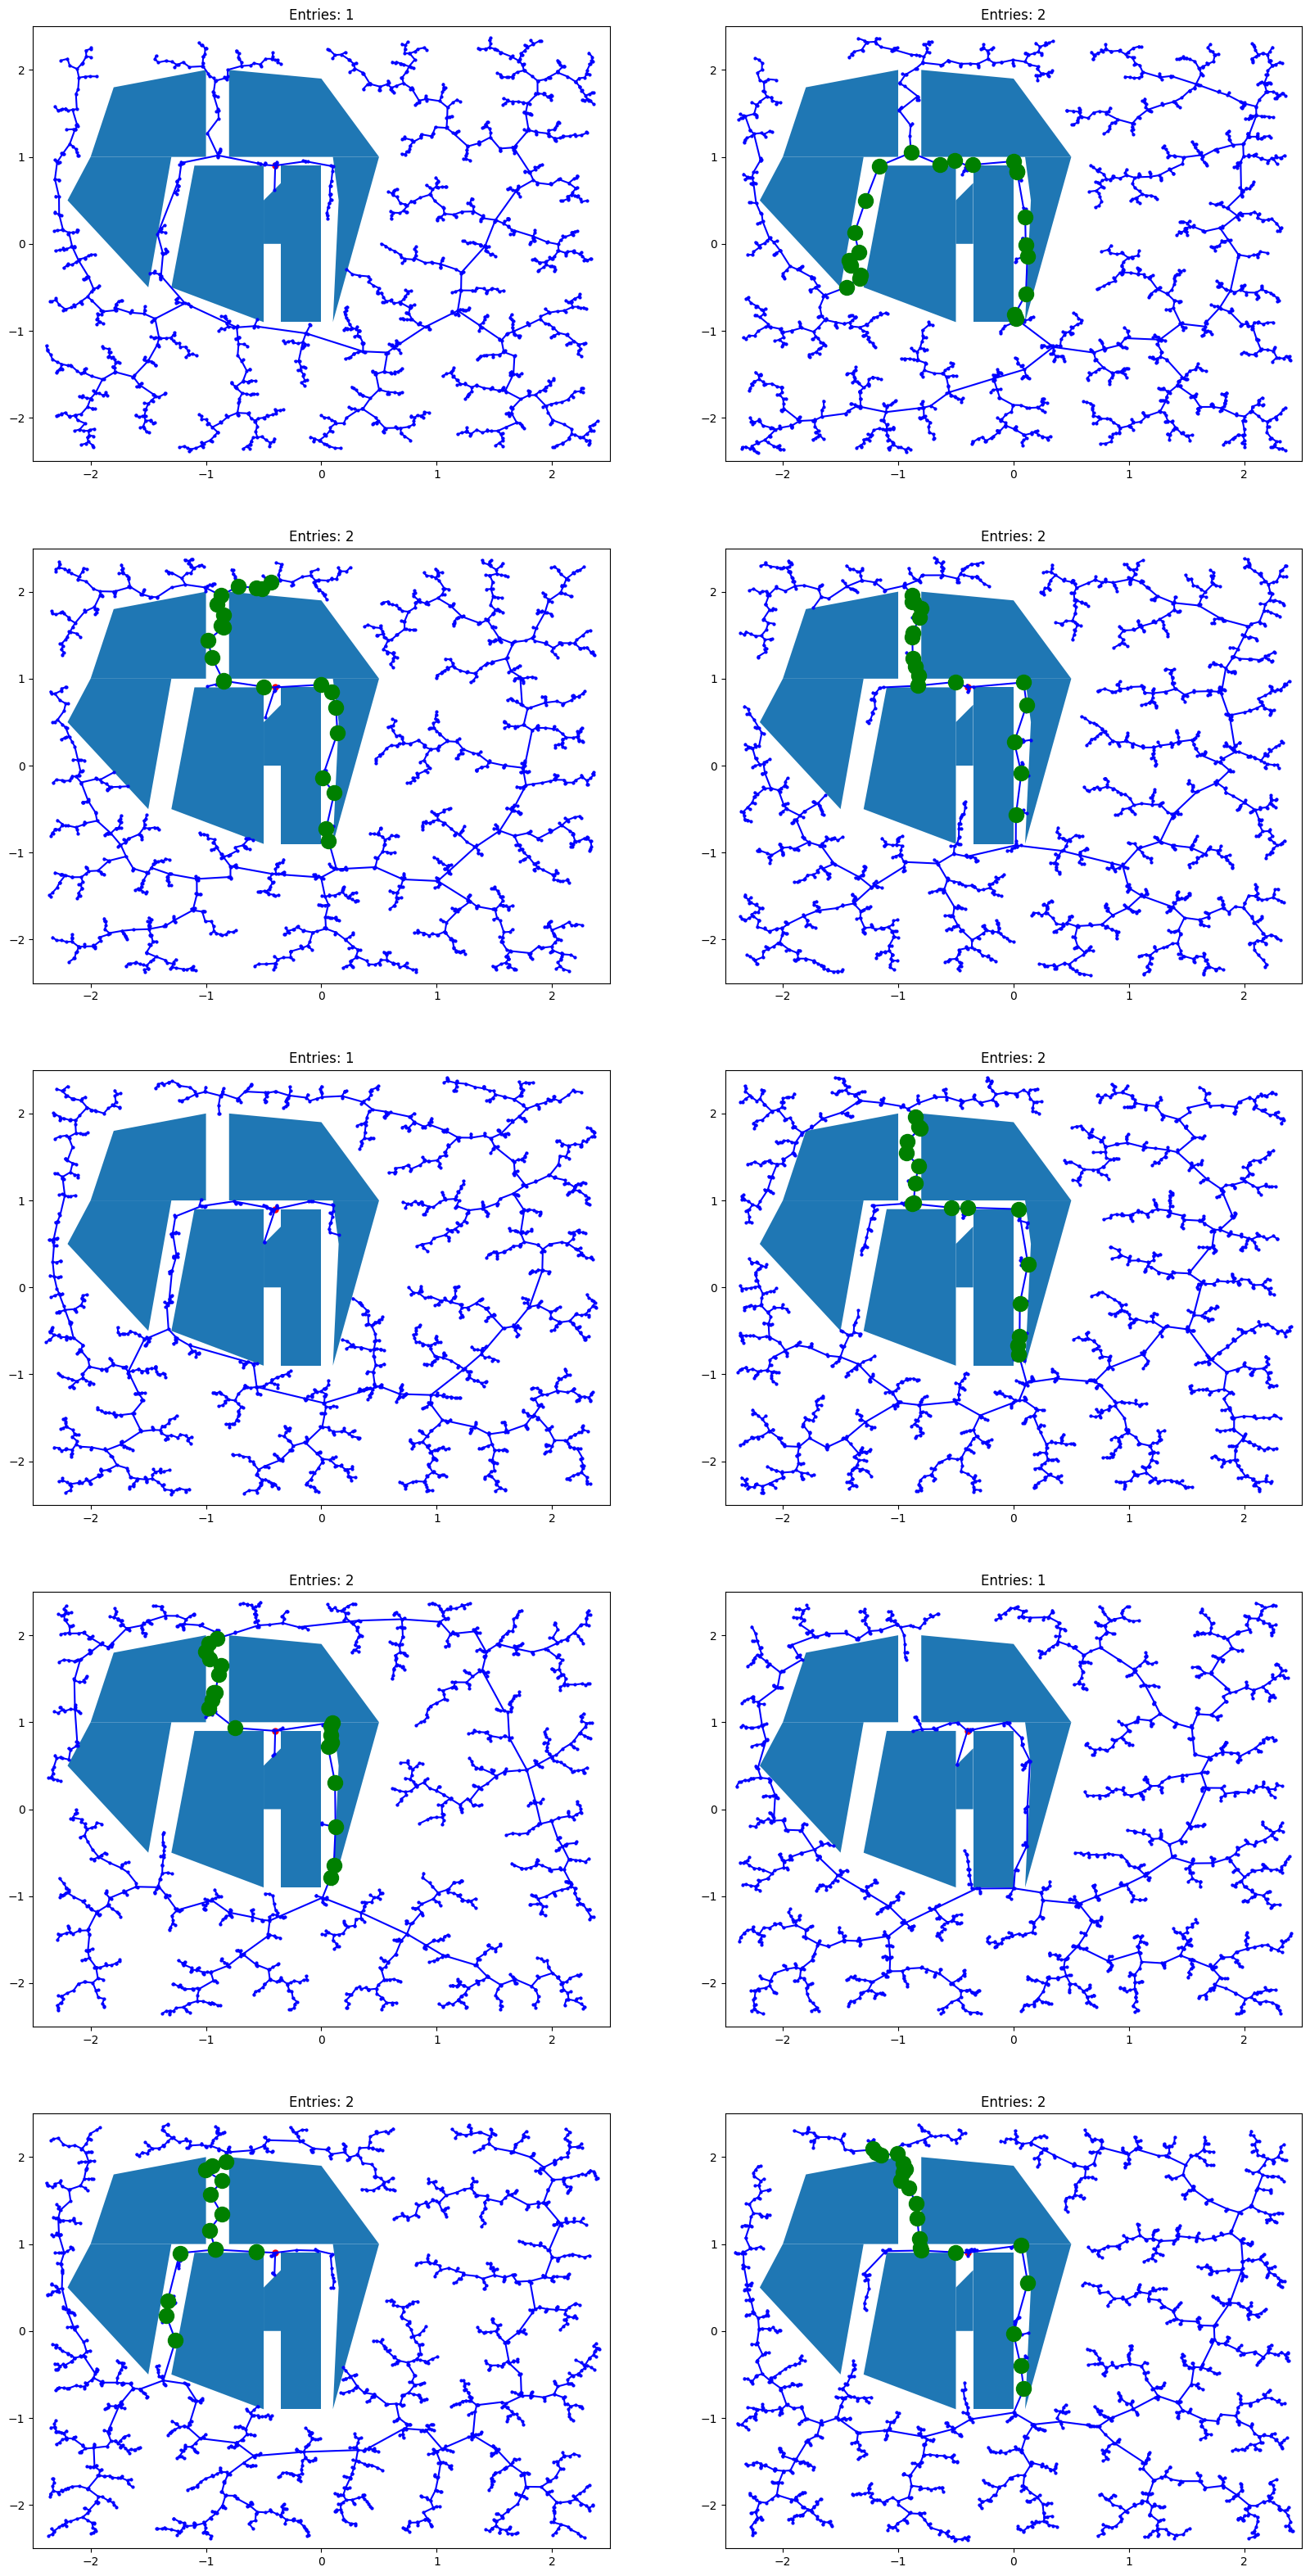

In [20]:
# Initialization
visualize = 1
maxiters  = 2500
# nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.25 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.20 # Extension parameter: this controls how far the RRT extends in each step.

# Start and goal positions
# xy_goal =  np.array([1,1]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize=20)

fig, axs = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(20)

for ax in axs.flat:
   
    draw_map(obstacles, ax)
    
    xy_start = np.array([-0.4, 0.9]); ax.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=5)
    # Initialize RRT. The RRT will be represented as a 2 x N list of points.
    # So each column represents a vertex of the tree.
    rrt = []
    start_node = Node()
    start_node.p = xy_start
    start_node.i = 0
    start_node.iPrev = 0
    rrt.append(start_node)

    entry_nodes = []
    tunnel_nodes = []


    # RRT algorithm
    start_time = time.time()
    iters = 0
    while iters < maxiters:
        # Sample point
        rnd = random()
        # With probability 0.05, sample the goal. This promotes movement to the goal.
        #if rnd < 0.05:
        #    xy = xy_goal
        #else:
            # Sample (uniformly) from space (with probability 0.95). The space is defined
            # with the bounds world_bounds_x and world_bounds_y defined above.
            # So, the x coordinate should be sampled in the interval
            # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
        xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
        # Check if sample is collision free
        collFree = isCollisionFreeVertex(obstacles, xy)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

        # If it is collision free, find closest point in existing tree. 
        closest_node = closestNode(rrt, xy)
        
        # Extend tree towards xy from closest_vert. Use the extension parameter
        # d defined above as your step size. In other words, the Euclidean
        # distance between new_vert and closest_vert should be d.
        new_node = Node()
        new_node.p = closest_node.p + d * (xy - closest_node.p)
        new_node.i = len(rrt)
        new_node.iPrev = closest_node.i

        # Check if new vertice is in collision
        collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue
        
            # If it is collision free, add it to tree    
        rrt.append(new_node)
        
        # check if outside
        new_outside = True
        prev_inside = False
    
        directions = [[0, 0.2],[0, -0.2],[0.2, 0],[-0.2, 0]]
        for i in range(4):
            # check if new node outside
            check_node_new = Node()
            check_node_new.p = [sum(x) for x in zip(new_node.p, directions[i])]
            new_outside = isCollisionFreeEdge(obstacles, check_node_new.p, new_node.p)
            if not new_outside:
                break
            
            # check if prev node outside
            prev_node = rrt[new_node.iPrev]
            check_node_prev = Node()
            check_node_prev.p = [sum(x) for x in zip(prev_node.p, directions[i])]
            prev_outside = isCollisionFreeEdge(obstacles, check_node_prev.p, prev_node.p)
            if not prev_outside:
                prev_inside = True
          
        if  new_outside and prev_inside:
            i_prev = new_node.iPrev
            in_used_branch = False
            potent_tunnel_nodes = []
            while i_prev != 0 and not in_used_branch:
                if i_prev in tunnel_nodes[7:] or i_prev in entry_nodes:
                    in_used_branch = True
                else:
                    potent_tunnel_nodes.append(i_prev)
                    i_prev = rrt[i_prev].iPrev
            if not in_used_branch:    
                tunnel_nodes.extend(potent_tunnel_nodes)
                entry_nodes.append(new_node.i)
        

        if visualize:
            # plt.plot(xy[0], xy[1], 'ro', color='k')
            ax.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=2) # VERTICES
            ax.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color='blue') # EDGES

        iters += 1

    if len(entry_nodes) > 1:
        '''
        for entry_node in entry_nodes:
            path_node = rrt[entry_node]
            while path_node.i != 0: 
                ax.plot(path_node.p[0],path_node.p[1],'bo',color='green', markersize=13)
                path_node = rrt[path_node.iPrev]
        '''
        for tunnel_node in tunnel_nodes:
            node = rrt[tunnel_node]
            ax.plot(node.p[0],node.p[1],'bo',color='green', markersize=13)
            
    ax.set_title('Entries: '+str(len(entry_nodes)))
    print('Number of iterations passed: %d / %d' %(iters, maxiters))
    print('RRT length: ', len(rrt))
    
    print('Entry nodes: ',len(entry_nodes))